# ASTRO 530 Homework 4 - Olivier Gilbert - Oct 29 2025

## 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.rc("axes", labelsize=16) 
T_eff = 5800*u.K # K
R_star = 1*cst.R_sun

wav = np.logspace(np.log10(0.05),np.log10(1000),100)*u.um

### a)

We start with a simple 2-component disk model

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/999799897.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/999799897.py:40: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color="purple", lw=2, label="Total disk")


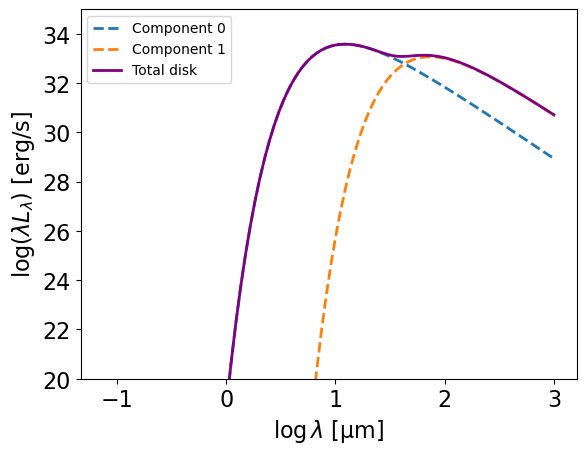

In [27]:
from scipy.integrate import quad
def planck(wav, T):
    if T == 0: return 0
    return 2*cst.h*cst.c**2*wav**(-5) / (np.exp(cst.h*cst.c/(wav*cst.k_B*T))-1)
class Disk:
    def __init__(self, spatial_extent, Temp):
        self.ri = spatial_extent[0]
        self.rf = spatial_extent[1]
        self.T = Temp
    def temp(self, r): # abstract method for temp
        return (self.T if r <= self.rf and r >= self.ri else 0)
    def L_lambda(self, wav):
        return (planck(wav, self.T) * (2*np.pi*(self.rf**2-self.ri**2))).to(u.erg / u.s / u.um)
    def __add__(self, disk2):
        return MultiDisk([self, disk2])

class MultiDisk:
    def __init__(self, disks):
        self.disks = disks
    def L_lambda(self, wav):
        L_lam = 0
        for i in range(len(self.disks)):
            L_lam += self.disks[i].L_lambda(wav)
        return L_lam
    def __str__(self):
        s = f"---Disk model---\n"
        for i, disk in enumerate(self.disks):
            s += f"\tComponent {i} : {disk.__str__()}\n"
        s += f"----------------\n"
        return s
    def __add__(self, disk2):
        if type(disk2) == MultiDisk:
            return MultiDisk(self.disks + disk2.disks)
        if type(disk2) != list:
            disk2 = [disk2]
        return MultiDisk(self.disks + disk2)
    def plot(self):
        for i, disk in enumerate(self.disks):
            plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
        plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color="purple", lw=2, label="Total disk")


disk1 = Disk((0.1*u.AU,5*u.AU),300*u.K)
disk2 = Disk((5*u.AU,100*u.AU),50*u.K)
model1 = disk1+disk2
model1.plot()
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()
plt.show()